In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os.path
import sys

import datasets

## 1. Compute RX background using typical images

Load the training and validation datasets

In [2]:
train_dir = "/home/jovyan/data/train_typical"

In [5]:
train_data, train_names = datasets.load_6f_images(train_dir, shuffle=True, remove_striped=True)

('Loaded dataset with shape:', (9124, 64, 64, 6))


We experimented with two different input representations for RX: pixelwise, in which the RX anomaly score is computed for each pixel in the image and aggregated into a single score for the entire image; and flat, in which the RX anomaly score is computed for the flattened image vector, i.e., the same representation used for PCA. 

To compute RX pixelwise, pass `pixelwise=True` to `compute_bg()`, and to compute RX flat, pass `pixelwise=False` to `compute_bg()`. In this example, we'll show pixelwise RX since this has better performance than flat RX for the Mastcam multispectral dataset.

In [6]:
def get_spectra(images):
    # returns all of the spectra in a set of images
    all_spectra = []
    for i in range(images.shape[0]):
        for col in range(images.shape[1]):
            for row in range(images.shape[2]):
                all_spectra.append(images[i,col,row])
    return np.array(all_spectra)

def compute_bg(train_images, pixelwise):
    # compute RX scores for individual pixels
    if pixelwise:
        # get all the spectra from the training dataset
        train_spectra = get_spectra(train_images)
        # compute mean spectrum
        mu = np.mean(train_spectra, axis=0)
        # compute covariance matrix of training spectra
        cov = np.cov(np.transpose(train_spectra))
        cov = np.linalg.inv(cov)
        return mu, cov
    else:
        # compute RX scores for entire image
        train_images = np.reshape(train_images, (train_images.shape[0], train_images.shape[1]*train_images.shape[2]*train_images.shape[3]))
        # compute mean image
        mu = np.mean(train_images, axis=0)
        # compute the covariance matrix for training images
        cov = np.cov(np.transpose(train_images))
        cov = np.linalg.inv(cov)
        return mu, cov

In [7]:
mu, cov = compute_bg(train_data, pixelwise=True)

## 2. Compute RX scores for test images

While the background statistics for RX are computed from only typical images, we test the novelty detection performance using both typical and novel images. 

In [8]:
test_dir_typical = "/home/jovyan/data/test_typical"

In [9]:
test_data_typical, test_names_typical = datasets.load_6f_images(test_dir_typical, shuffle=False, remove_striped=True)

('Loaded dataset with shape:', (420, 64, 64, 6))


Compute RX anomaly scores for the typical test images

In [14]:
def compute_rx_score(images, mu, cov, pixelwise):
    # compute RX scores for individual pixels
    if pixelwise:
        # create an array to hold aggregated RX scores
        rx_scores = np.ndarray(images.shape[0])
        for i in range(rx_scores.shape[0]):
            img = images[i]
            # create a placeholder for RX scores
            rx_image = np.ndarray(img.shape[:2])
            # compute RX score at each pixel location
            for col in range(rx_image.shape[0]):
                for row in range(rx_image.shape[1]):
                    sub = np.expand_dims(img[col,row]-mu, axis=0)
                    rx_image[col,row] = np.dot(np.dot(sub, cov), sub.T)
            # aggregate the RX scores for each image
            rx_scores[i] = np.mean(rx_image)
        return rx_scores
    else:
        # compute RX score for each flattened image vector
        rx_scores = np.ndarray(images.shape[0])
        # flatten the images
        images = np.reshape(images, (images.shape[0], images.shape[1]*images.shape[2]*images.shape[3]))
        # compute the RX score for each image
        for i in range(images.shape[0]):
            sub = np.expand_dims(images[i]-mu, axis=0)
            rx_scores[i] = np.dot(np.dot(sub, cov), sub.T)
        return rx_scores

In [15]:
scores_typical = compute_rx_score(test_data_typical, mu, cov, pixelwise=True)

Compute RX anomaly scores for each subcategory of novel test images as well as all novel test images

In [16]:
test_dir_novel = "/home/jovyan/data/test_novel"

In [17]:
input_novel = {}
scores_novel = {}
novel_categories = ['all', 'bedrock', 'broken-rock', 'drill-hole', 'drt', 'dump-pile', 'float', 'meteorite', 'veins']
for cat in novel_categories:
    # Load the dataset
    data, names = datasets.load_6f_images(os.path.join(test_dir_novel, cat), shuffle=False, remove_striped=True)
    input_novel[cat] = data
    scores_novel[cat] = compute_rx_score(data, mu, cov, pixelwise=True)

('Loaded dataset with shape:', (430, 64, 64, 6))
('Loaded dataset with shape:', (11, 64, 64, 6))
('Loaded dataset with shape:', (76, 64, 64, 6))
('Loaded dataset with shape:', (62, 64, 64, 6))
('Loaded dataset with shape:', (111, 64, 64, 6))
('Loaded dataset with shape:', (93, 64, 64, 6))
('Loaded dataset with shape:', (18, 64, 64, 6))
('Loaded dataset with shape:', (34, 64, 64, 6))
('Loaded dataset with shape:', (30, 64, 64, 6))


Plot the distribution of novelty scores for each class

Text(0,0.5,'Density')

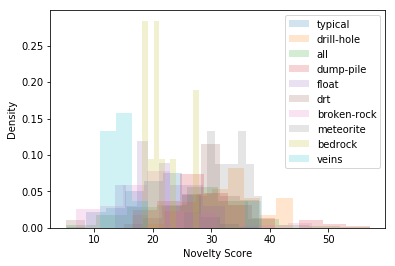

In [18]:
plt.hist(scores_typical, alpha=0.2, label='typical', density=True)
for cat in scores_novel.keys():
    plt.hist(scores_novel[cat], alpha=0.2, label=cat, density=True)
plt.legend()
plt.xlabel('Novelty Score')
plt.ylabel('Density')

## 3. Evaluate RX performance for novelty detection

We used two metrics for quantitatively evaluating performance: area under the curve (AUC) of the receiver operator characteristic (ROC) curve and precision at N. Precision at N is the fraction of correct classifications in the top N images when sorted by novelty score (i.e., the fraction of novel images in the top N test images sorted by novelty score).

### Compute AUC scores

In [19]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

Text(0.5,0,'True positive rate')

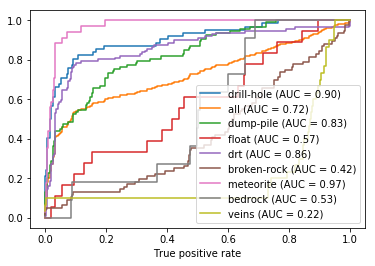

In [20]:
for cat in scores_novel.keys():
    scores = np.concatenate([scores_typical, scores_novel[cat]])
    labels = np.concatenate([np.zeros(scores_typical.shape), np.ones(scores_novel[cat].shape)])
    fpr, tpr, thresholds = roc_curve(y_true=labels, y_score=scores)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (cat, auc_score))
plt.legend()
plt.xlabel("False positive rate")
plt.xlabel("True positive rate")

### Compute Precision at N

Sort the combined test dataset (novel and typical images) by their novelty score

In [21]:
test_data_novel, test_names_novel = datasets.load_6f_images(os.path.join(test_dir_novel, 'all'), shuffle=False, remove_striped=True)

('Loaded dataset with shape:', (430, 64, 64, 6))


In [24]:
combined_scores = np.concatenate([scores_typical, scores_novel['all']])

In [25]:
combined_labels = np.concatenate([np.zeros(scores_typical.shape), np.ones(scores_novel['all'].shape)])

In [26]:
combined_inputs = np.concatenate([test_data_typical, test_data_novel])

In [27]:
combined_names = np.concatenate([test_names_typical, test_names_novel])

In [28]:
# Sort the scores, labels, filenames, and inputs by novelty score 
sorted_scores = sorted(zip(combined_scores, combined_labels, combined_names, combined_inputs), key=lambda tup: tup[0], reverse=True)
combined_scores, combined_labels, combined_names, combined_inputs = zip(*sorted_scores)

Compute Precision at N for the top-ranked images

In [29]:
# Choose the top N
N = 10
top_scores = combined_scores[:N]
top_labels = combined_labels[:N]
top_names = combined_names[:N]
top_images = combined_inputs[:N]

Precision at N=10: 1.000000


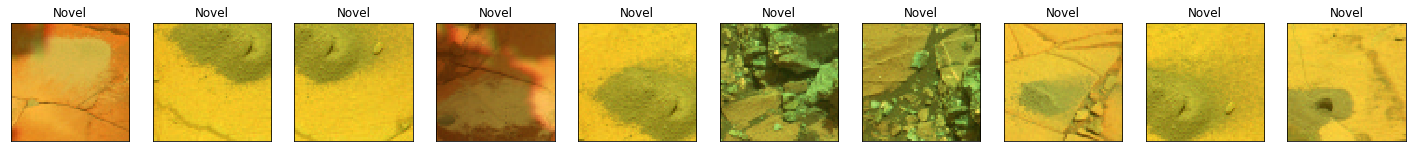

In [30]:
fig, axes = plt.subplots(ncols=N, figsize=(25, 15))
for i, img in enumerate(top_images):
    img = np.take(img, [2,0,1], axis=2)
    axes[i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
    axes[i].grid(False)
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
    if top_labels[i] == 0:
        axes[i].set_title('Typical')
    elif top_labels[i] == 1:
        axes[i].set_title('Novel')

precision_at_N = len(np.where(np.array(top_labels) == 1)[0])
precision_at_N = precision_at_N / float(N)
print("Precision at N=%d: %f" % (N, precision_at_N))

### Compute False Negatives at N

False Negatives at N is the fraction of novel images that appear in the bottom N images when ranked by novelty score.

In [31]:
# Choose the bottom N
bottom_scores = combined_scores[-N:]
bottom_labels = combined_labels[-N:]
bottom_names = combined_names[-N:]
bottom_images = combined_inputs[-N:]

Precision at N=10: 0.400000


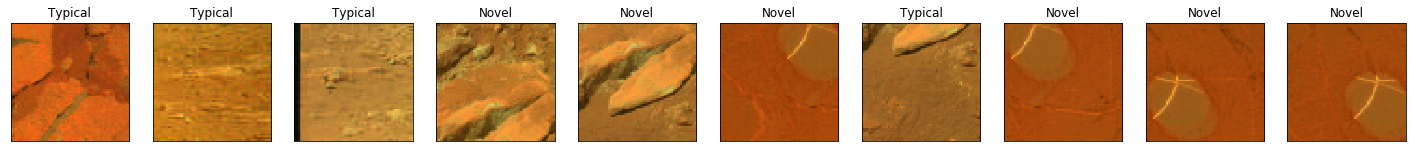

In [32]:
fig, axes = plt.subplots(ncols=N, figsize=(25, 15))
for i, img in enumerate(bottom_images):
    img = np.take(img, [2,0,1], axis=2)
    axes[i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
    axes[i].grid(False)
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
    if bottom_labels[i] == 0:
        axes[i].set_title('Typical')
    elif bottom_labels[i] == 1:
        axes[i].set_title('Novel')

precision_at_N = len(np.where(np.array(bottom_labels) == 0)[0])
precision_at_N = precision_at_N / float(N)
print("Precision at N=%d: %f" % (N, precision_at_N))